## 1. Importing Libraries and Vocabulary

In [1]:
import json
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_non_alphanum
from nltk import word_tokenize
import nltk
import numpy as np

In [2]:
# you only need to do this once!
# for this tutorial, I downloaded "popular", though I don't know if I could get away with something smaller
#import nltk
#nltk.download()

## 2. Downloading Data

The caselaw download is available at https://case.law

Caselaw proves "all official, book-published United States case law — every volume designated as an official report of decisions by a court within the United States." You might want to spend some time on the site getting more familar with the data and thinking how you might want to analyze it. 

Data is available as an API and as a bulk JSON or XML formatted download. Because we will be working with large numbers of records, we'll use the bulk download. Public downloads are avialable for Arkansas, Illinios, and New Mexico. This workshop will use the JSON format. 

https://case.law/bulk/download/

To get the JSON formatted data, download the TEXT version (rather than the XML version). To extract the data, you'll need to first unzip the download file "Illinois-20190416-text.zip" (the exact name of this file contains a date stamp, yours may be different). The unzipped file will contain a "data" folder that contains a "data.json.xz" file, which is another compressed file. You'll need to unpack this file - one way is to use the xz utility. 

%: xz -d data.jsonl.xz

You can work with it using the json library in python. For this workshop, I renamed it illinois_data.json1 and put it in a folder named caselaw_data, since I plan to work with data from other states as it becomes available. 

## 3. Importing Data

In the next step, we'll read the data into a list using the json library. One thing to keep in mind here is that the file is very large and will likely overwhelm your laptop. You may eventually want to move to a cluster to process larger amounts of data. For now, let's limit the number of rows to 1000 to get the code up and running. We can increase it later. Keep in mind, the data may be chronologically ordered, so the first 1000 is not a random sampling of this data!

In [3]:
max_records = 1000

data = []
with open('caselaw_data/illinois_data.jsonl') as f:
    for i, line in enumerate(f):
        data.append(json.loads(line))
        #if i % 1000 == 0:
        #    print(i, "processed")
        # set max of 10,000 rows for now, increase or remove this to get the entire data set
        if i > max_records:
            break

The approach to parsing a "jsonl" differs slightly from parsing a single JSON document - in the jsonl format, each row containes a line object representing a JSON document. Here's the first one...

In [4]:
data[0]

{'casebody': {'data': {'attorneys': ['Michael Ratliff-El, of Pontiac, appellant pro se.',
    'Lisa Madigan, Attorney General, of Chicago (Joel D. Bertocchi, Solicitor General, and Richard S. Huszagh, Assistant Attorney General, of counsel), for appellee.'],
   'head_matter': 'MICHAEL RATLIFF-EL, Plaintiff-Appellant, v. KENNETH R. BRILEY, Defendant-Appellee.\nThird District\nNo. 3—01—0727\nOpinion filed May 2, 2003.\nMichael Ratliff-El, of Pontiac, appellant pro se.\nLisa Madigan, Attorney General, of Chicago (Joel D. Bertocchi, Solicitor General, and Richard S. Huszagh, Assistant Attorney General, of counsel), for appellee.',
   'judges': [],
   'opinions': [{'author': 'PRESIDING JUSTICE McDADE',
     'text': 'PRESIDING JUSTICE McDADE\ndelivered the opinion of the court:\nMichael Ratliff-El filed a complaint for mandamus relief (735 ILCS 5/14 — 101 et seq. (West 2000)) naming Kenneth R. Briley, warden of the Stateville Correctional Center, as the defendant. The trial court granted the

The JSON libary in python stores each document as a dictionary object type

In [5]:
type(data[0])

dict

## 4. Extracting and Cleaning Data

For this workshop, we'll work only with the text of the court decision. If you're interested in other fields, you can expand the loop below to extract other elements of the JSON document.

The exact strategy you employ to clean data can be very dependent on the type of analysis you want to do. This workshop will cover a few common strategies:

* removing non alphanumeric characters
* removing common stop words
* removing very short or long words
* removing purely numerical data
* removing words that are not in a particular corpus (such as the oxford english dictionary)

Again, these are common techniques, but depending on your study and data, they may not be necessary or even advisable. The strategy you take will emerge from your data and the type of analysis you plan to do.


### Removing non alphanumeric characters

This loop uses the gemsin library to strip non alphanumeric characters. It also collapses multiple spaces into a single space.

In [6]:
tokenized_sentences = []
        
opinion_texts = []
for i in range(len(data)):
    if data[i]['casebody']['data']['opinions']:
        text = data[i]['casebody']['data']['opinions'][0]['text'].lower()
        text = strip_non_alphanum(text)
        opinion_texts.append(' '.join(text.split()))
       

Here's the output from the first record. Take a look at this as compared to the text from the raw JSON file. Non alphanumeric characters are gone, but you can still read the text and understand what it means. However, you may already be able to see how cleaning data can result in loss of precision.

As an exercise, take a look at the original document and consider if there are any terms you'd be interested in preserving that may be lost through the data transformation here. 

In [7]:
opinion_texts[0]

'presiding justice mcdade delivered the opinion of the court michael ratliff el filed a complaint for mandamus relief 735 ilcs 5 14 101 et seq west 2000 naming kenneth r briley warden of the stateville correctional center as the defendant the trial court granted the defendant s motion to dismiss under section 2 615 of the code of civil procedure 735 ilcs 5 2 615 west 2000 on appeal ratliff el argues that the trial court erred by dismissing his complaint because it stated a cause of action for mandamus relief we affirm background ratliff el is a prisoner at stateville in his complaint ratliff el contended that the defendant had a clear duty to follow the illinois administrative procedure act act 5 ilcs 100 1 1 et seq west 2000 during adjustment committee and grievance proceedings at stateville as a result of such proceedings ratliff el had been disciplined with revocation of good time credits ratliff el submitted that he was entitled to mandamus relief because the defendant had failed t

### Remove stopwords

The above text still contains a large number of "stop words", common words that may not too ubiquitous to be useful (emphasis on the *may*). Words like "a", "they", "and" increase the word count and require extra processing time and computing resources, and may not be helpful in your analysis. 

The loop below uses the gensim utility to remove common stopwords

In [8]:
for i in range(len(opinion_texts)):
    opinion_texts[i] = remove_stopwords(opinion_texts[i])

In [9]:
opinion_texts[0]

'presiding justice mcdade delivered opinion court michael ratliff el filed complaint mandamus relief 735 ilcs 5 14 101 et seq west 2000 naming kenneth r briley warden stateville correctional center defendant trial court granted defendant s motion dismiss section 2 615 code civil procedure 735 ilcs 5 2 615 west 2000 appeal ratliff el argues trial court erred dismissing complaint stated cause action mandamus relief affirm background ratliff el prisoner stateville complaint ratliff el contended defendant clear duty follow illinois administrative procedure act act 5 ilcs 100 1 1 et seq west 2000 adjustment committee grievance proceedings stateville result proceedings ratliff el disciplined revocation good time credits ratliff el submitted entitled mandamus relief defendant failed follow act procedures alleged defendant s failure follow act procedures violated rights defendant filed section 2 615 motion dismiss ratliff el s mandamus complaint failure state cause action motion dismiss defend

### Remove very long or short words
### Remove purely numerical data

The text still contains a large number of short or purely numeric characters. These may or may not contain valuable information - for now, we'll remove them. 

In [10]:
for i in range(len(opinion_texts)):
    opinion_texts[i] = ' '.join([s for s in opinion_texts[i].split() if len(s) > 1 or s.isdigit() == False])

In [11]:
opinion_texts[0]

'presiding justice mcdade delivered opinion court michael ratliff el filed complaint mandamus relief 735 ilcs 14 101 et seq west 2000 naming kenneth r briley warden stateville correctional center defendant trial court granted defendant s motion dismiss section 615 code civil procedure 735 ilcs 615 west 2000 appeal ratliff el argues trial court erred dismissing complaint stated cause action mandamus relief affirm background ratliff el prisoner stateville complaint ratliff el contended defendant clear duty follow illinois administrative procedure act act ilcs 100 et seq west 2000 adjustment committee grievance proceedings stateville result proceedings ratliff el disciplined revocation good time credits ratliff el submitted entitled mandamus relief defendant failed follow act procedures alleged defendant s failure follow act procedures violated rights defendant filed section 615 motion dismiss ratliff el s mandamus complaint failure state cause action motion dismiss defendant argued act a

### Removing words that are not in a particular corpus (such as the oxford english dictionary)

You may have noticed that there are a number of words such as "jj" above that are nor part of the standard english language. These may be the result of data cleaning (such as artifacts of markup language). They may also be the result of legal language or other important data. As always, cleaning data is a decision you make that may or may not be necessary or desirable. 

In [12]:
words = set(nltk.corpus.words.words())

for i in range(len(opinion_texts)):
    opinion_texts[i] = ' '.join([s for s in opinion_texts[i].split() if s in words])

In [13]:
opinion_texts[0]

'justice opinion court el complaint mandamus relief west naming r warden correctional center defendant trial court defendant s motion dismiss section code civil procedure west appeal el trial court complaint stated cause action mandamus relief affirm background el prisoner complaint el defendant clear duty follow administrative procedure act act west adjustment committee grievance result el revocation good time el mandamus relief defendant follow act defendant s failure follow act defendant section motion dismiss el s mandamus complaint failure state cause action motion dismiss defendant act apply adjustment committee grievance department doc trial court defendant s motion dismiss el analysis motion dismiss mandamus action doc duty follow act el state agency follow act doc state agency adjustment committee grievance meet statutory definition defendant clear duty follow act doc adjustment committee grievance trial court defendant s motion dismiss mandamus cause action defendant act clau

## 5. Tokenize the sentences

We've cleaned the data, but it is still stored in large blocks of text. The next step, *tokenization*, will convert each line into a list of individual words. 

In [14]:
 for text in opinion_texts:
    tokenized_sentences.append(word_tokenize(text))

In [15]:
tokenized_sentences[0][:50]

['justice',
 'opinion',
 'court',
 'el',
 'complaint',
 'mandamus',
 'relief',
 'west',
 'naming',
 'r',
 'warden',
 'correctional',
 'center',
 'defendant',
 'trial',
 'court',
 'defendant',
 's',
 'motion',
 'dismiss',
 'section',
 'code',
 'civil',
 'procedure',
 'west',
 'appeal',
 'el',
 'trial',
 'court',
 'complaint',
 'stated',
 'cause',
 'action',
 'mandamus',
 'relief',
 'affirm',
 'background',
 'el',
 'prisoner',
 'complaint',
 'el',
 'defendant',
 'clear',
 'duty',
 'follow',
 'administrative',
 'procedure',
 'act',
 'act',
 'west']

## 6. Fitting/Training a Model

In [16]:
model = gensim.models.Word2Vec(tokenized_sentences, size=100, window=5, min_count=1, 
                               sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

## 7. Investigate Word Embeddings

### So... what is produced?

Gensim uses a neural network to assign a multidimensional vector that captures the semantic relationship of this word to all the other words in the corpus. 

Here's what these vectors look like:

In [17]:
model.wv['bad']

array([ 0.00701938,  0.22094099, -0.15280345, -0.50170106, -0.27767855,
        0.51009   ,  0.02911096,  0.40067425,  0.14857315, -0.10556585,
        0.51372594, -0.48644233,  0.06245834, -0.32191032, -0.09962041,
        0.04739412, -0.03328784, -0.42241785, -0.08324668, -0.24245842,
       -0.20356582,  0.56792104,  0.03647023, -0.09189005,  0.17705068,
        0.14200348,  0.18672164,  0.20708947, -0.07524716, -0.406505  ,
        0.6346041 ,  0.2355772 , -0.20756352,  0.05427392, -0.06049706,
        0.2637598 ,  0.354273  ,  0.09091789,  0.24763025, -0.50954473,
        0.06509677, -0.28176588, -0.05760124, -0.58445543, -0.30940828,
       -0.48035797, -0.1267416 , -0.01961134,  0.14403361,  0.11418576,
        0.23265237,  0.28409806,  0.1919261 , -0.15587963, -0.74528646,
       -0.47695988,  0.26640132, -0.06748142, -0.47188064, -0.11900415,
       -0.35109052,  0.11595055,  0.20724599,  0.25475547, -0.5731801 ,
        0.33086613,  0.16601874, -0.10529891, -0.40076622, -0.14

### Comparing semantic similarity of words

The similarity of one word to another in the corpus can be calculated using the cosine similarity of the vectors assigned to each word. Note that the semantic similarity may not capture all aspects of a word. For instance, antonymns may be used in such similar sentence structure that they have similar word vectors, even though they have opposite meanings. 

First, let's use Gensim to find the words with the highest cosine similarity to an existing word.

In [18]:
model.wv.most_similar('bad')

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('faith', 0.7902333736419678),
 ('unconscionably', 0.7755246162414551),
 ('unconscionable', 0.7361494302749634),
 ('debarment', 0.6967447400093079),
 ('inducement', 0.6940716505050659),
 ('unclean', 0.6791157722473145),
 ('partiality', 0.6756536960601807),
 ('unjustifiably', 0.6710824966430664),
 ('good', 0.6697852611541748),
 ('unexcused', 0.6653245687484741)]

### Words with different contexts

You may notice that many of the words associated with "bad" represent different contexts. Bad can mean immoral, insincere, or untrue. We can use gensim to remove certain contexts or emphasize others when searching for words with similar semantic usage.

In [19]:
model.wv.most_similar(positive=['bad','trouble'])

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hesitant', 0.8060867190361023),
 ('fateful', 0.7999908924102783),
 ('hoped', 0.798568606376648),
 ('fay', 0.798460841178894),
 ('yesterday', 0.7982237935066223),
 ('blamed', 0.7972657680511475),
 ('unconscionably', 0.7965033054351807),
 ('inquiring', 0.7960062026977539),
 ('detract', 0.7949225902557373),
 ('animosity', 0.7947283983230591)]

In [20]:
model.wv.most_similar(positive=['bad','trouble'])

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hesitant', 0.8060867190361023),
 ('fateful', 0.7999908924102783),
 ('hoped', 0.798568606376648),
 ('fay', 0.798460841178894),
 ('yesterday', 0.7982237935066223),
 ('blamed', 0.7972657680511475),
 ('unconscionably', 0.7965033054351807),
 ('inquiring', 0.7960062026977539),
 ('detract', 0.7949225902557373),
 ('animosity', 0.7947283983230591)]

You can combine positive and negative context as you search for words with similar vectors.

In [21]:
model.wv.most_similar(positive=['bad','faith'], negative=['bad','trouble'])

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('good', 0.33755171298980713),
 ('covenant', 0.3333086371421814),
 ('unconscionable', 0.3154163658618927),
 ('dealing', 0.2948612570762634),
 ('franchise', 0.28714901208877563),
 ('expulsion', 0.276449978351593),
 ('uniformity', 0.27462899684906006),
 ('inequitable', 0.27393051981925964),
 ('breach', 0.26943618059158325),
 ('unjust', 0.2682061791419983)]

### Semantic similarity of two words

You can use Gensim to retrieve the semantic similarity of two words. This operation will return the cosine similarity between the terms.

In [22]:
print(model.wv.similarity('bad', 'faith'))

0.7902334


/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Calculating the cosine similarity

We can get the vectors for each word and calculate the cosine directly

In [23]:
unconscionably_vec = model.wv['bad']
bad_vec = model.wv['faith']

cos_sim = np.dot(bad_vec, unconscionably_vec) / (np.linalg.norm(bad_vec) * np.linalg.norm(unconscionably_vec))

print(cos_sim)

0.7902334


### Working directly with vectors

Gensim has an API to work direcly with vectors rather than terms. 

In [24]:
model.wv.similar_by_vector('bad', 10)

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('faith', 0.7902333736419678),
 ('unconscionably', 0.7755246162414551),
 ('unconscionable', 0.7361494302749634),
 ('debarment', 0.6967447400093079),
 ('inducement', 0.6940716505050659),
 ('unclean', 0.6791157722473145),
 ('partiality', 0.6756536960601807),
 ('unjustifiably', 0.6710824966430664),
 ('good', 0.6697852611541748),
 ('unexcused', 0.6653245687484741)]

In [25]:
model.wv.similar_by_vector(bad_vec, 10)

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('faith', 1.0),
 ('good', 0.8285004496574402),
 ('bad', 0.7902333736419678),
 ('dealing', 0.6986989974975586),
 ('unconscionably', 0.693325936794281),
 ('unconscionable', 0.6815456748008728),
 ('debarment', 0.6797981858253479),
 ('negotiate', 0.6335129141807556),
 ('magistrate', 0.6237947344779968),
 ('exclusionary', 0.6162017583847046)]

In [26]:
print(len(bad_vec))
print(type(bad_vec))
print(bad_vec)

100
<class 'numpy.ndarray'>
[ 0.19991836  0.42959315 -0.00195875 -0.50486654 -0.03483067  0.4531444
  0.03078997  0.56425565  0.04899023  0.03497435  1.0157025  -0.442698
  0.25807434 -0.3602112  -0.23702817 -0.38652173 -0.13934714 -0.25396425
 -0.08340971 -0.39310342 -0.28394803  0.51564896  0.11429871  0.0154471
  0.34896383  0.25200263  0.37118024 -0.10311092  0.00720619 -0.26121753
  0.43502763  0.5238067   0.1720223  -0.22057085 -0.2518186   0.44024298
  0.04365176  0.04491034  0.31403553 -0.9051641   0.00958377 -0.19553095
 -0.02772343 -1.3258141   0.01980148 -0.69993716 -0.34998187 -0.29732952
  0.45311156  0.22171363 -0.06907912  0.07873448  0.6786062   0.33023342
 -0.7220933  -0.452502    0.05017934 -0.06889845 -0.29777956 -0.4275067
 -0.57381713 -0.18528908 -0.27523342  0.27520064 -0.40500543  0.12614888
  0.4314285   0.07553516 -0.4301024  -0.44571438 -0.09112114  0.54893994
  0.3462697   0.26099944  0.60331875 -0.18179591  0.05178003 -0.09654211
  0.20948063 -0.8506334  -0.

You can create vectors yourself and find terms with semantic similarity

In [27]:
vec = np.random.uniform(-1, 1, 100)
model.wv.similar_by_vector(vec, 10)

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('returned', 0.21916073560714722),
 ('clear', 0.21503575146198273),
 ('negligence', 0.1905280351638794),
 ('left', 0.18542763590812683),
 ('uniform', 0.1840793341398239),
 ('stood', 0.17986328899860382),
 ('change', 0.17397582530975342),
 ('convincing', 0.16768872737884521),
 ('neglect', 0.16739225387573242),
 ('seat', 0.16583484411239624)]

## 7. Plotting And Visualization

For this exercise, we'll visualize the degree of positive and netagive semantic association of virtues and vices with "good" and "bad".

I left a few of the virtues and vices out for this exercise - you may need to increase the number of records you process to include all these words, and you may need to increase it more to get good or interesting associations. For now, I'd recommend you keep it small and get it running, you can expand once you have the code working.

In [28]:
virtues_vices = ['courage', 'charity', 'honor', 'truth', 'honesty', 'greed', 'cruelty', 'pride']

In [29]:
bad_score = [model.wv.similarity(['bad'], word) for word in virtues_vices]
good_score = [model.wv.similarity(['good'], word) for word in virtues_vices]

/Users/boushey/anaconda/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

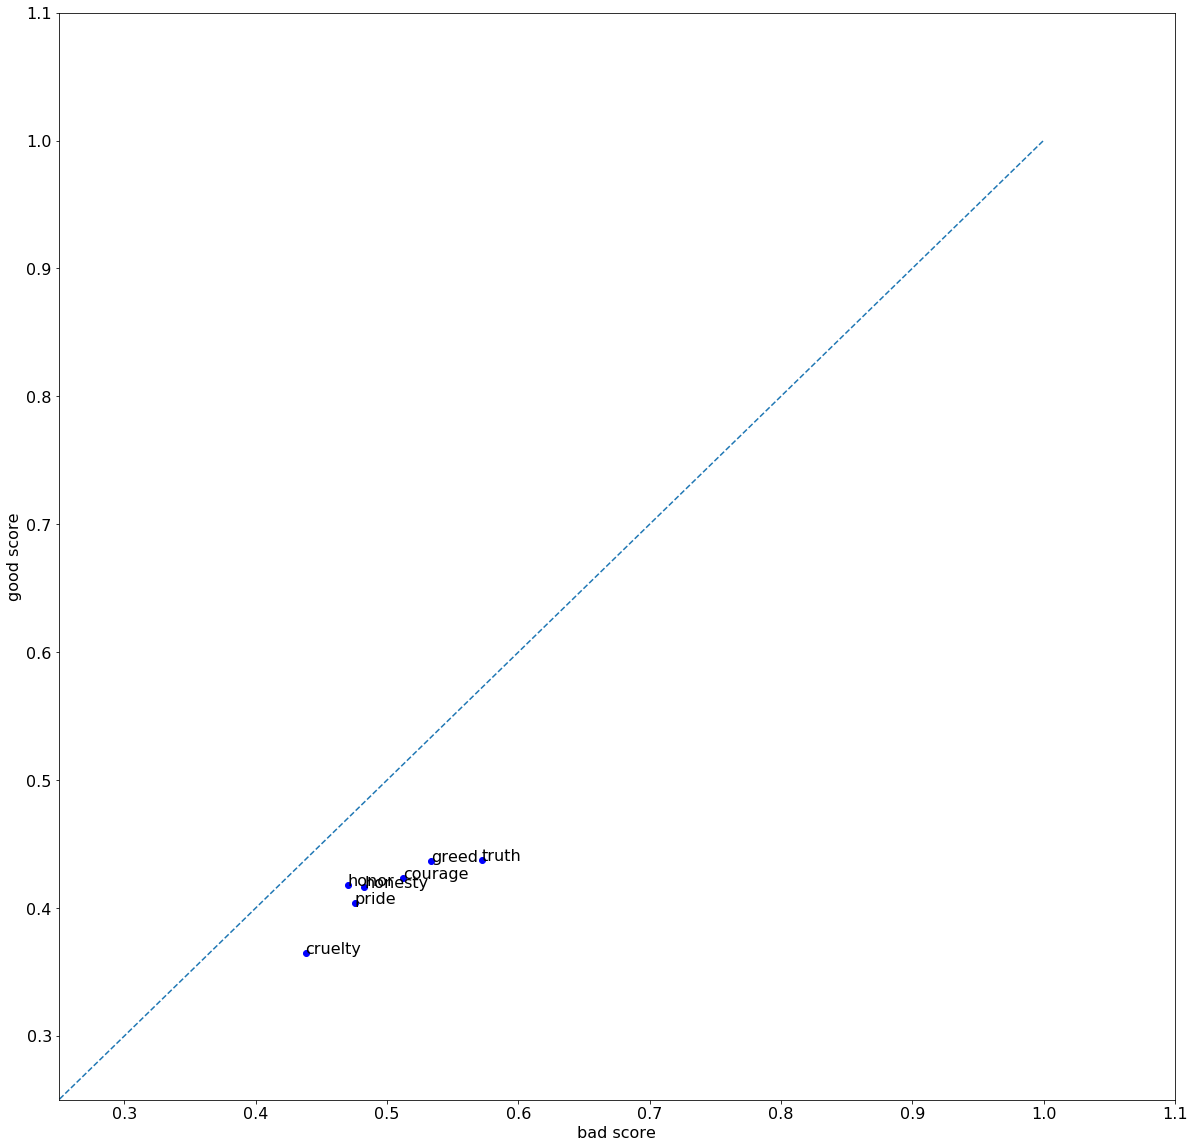

In [31]:
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(bad_score, good_score, alpha=1, color='b')
for i in range(len(virtues_vices)):
    ax.annotate(virtues_vices[i], (bad_score[i], good_score[i])).set_fontsize(16)
ax.set_xlim(.25, 1.1)
ax.set_ylim(.25, 1.1)
ax.yaxis.label.set_fontsize(16)
ax.xaxis.label.set_fontsize(16)
plt.xlabel('bad score')
plt.ylabel('good score')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.plot([0, 1], [0, 1], linestyle='--');